<a href="https://colab.research.google.com/github/EdisonWang00/store-sales-prediction-project/blob/main/store_sales_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from google.colab import files
from time import time
import os

# statistics
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [ ]:
data = files.upload()

# data uploading

In [7]:

store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train = pd.read_csv('train.csv', index_col='Date', parse_dates = True)
#setting index column is useful when working with time series data, where the 'Date' column represents the timestamps or dates associated with the data points.
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


#Part A  (EDA)


In [10]:
train.shape

(1017209, 8)

the training dataset has 1 million observations over two years. we need to do some feature engineering to make it easier for analysis.

In [11]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

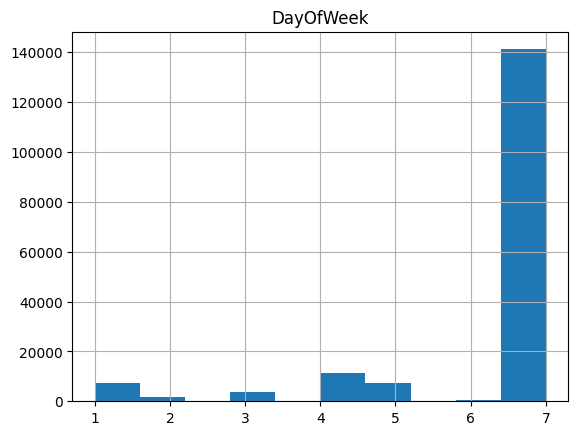

In [54]:
# I want to know when is the store close
store_close = train[(train.Open ==0)]
store_close.hist('DayOfWeek')

<Axes: >

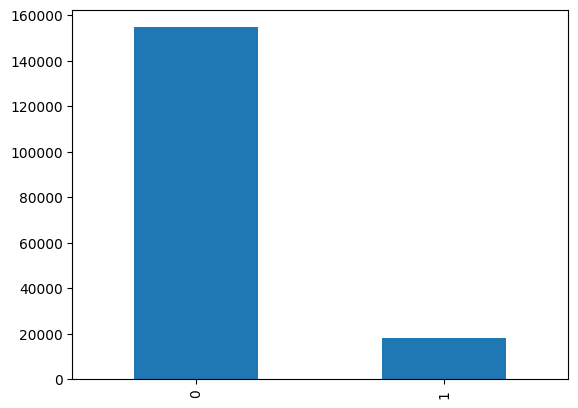

In [12]:
store_close['SchoolHoliday'].value_counts().plot(kind = 'bar')

<Axes: >

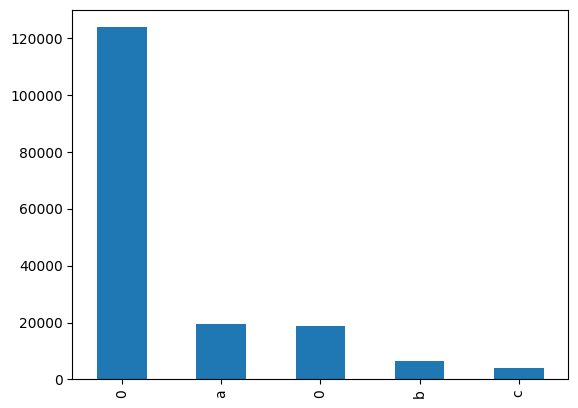

In [13]:
store_close['StateHoliday'].value_counts().plot(kind="bar")
# We can see from the above plot that stores were mostly closed on 7th day

In [14]:
train.isnull().sum()

##there is not missing value

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64

In [15]:
# percentage of days where store is close
per =(train[(train.Open == 0)].shape[0]) / train.shape[0]
print(per)

0.16989330609540418


In [16]:
store.isnull().sum()
## need to check missing value for store dataframe

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [17]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),inplace=True)
# replace missing value with median

In [18]:
store.fillna(0,inplace=True)
## replace NA data with 0

In [19]:
train_store_joined = pd.merge(train,store, on= 'Store',how = 'inner')
train_store_joined.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [20]:
 #Distribution of sales and customers across store types
 train_store_joined.groupby('StoreType')['Customers','Sales'].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


<Axes: >

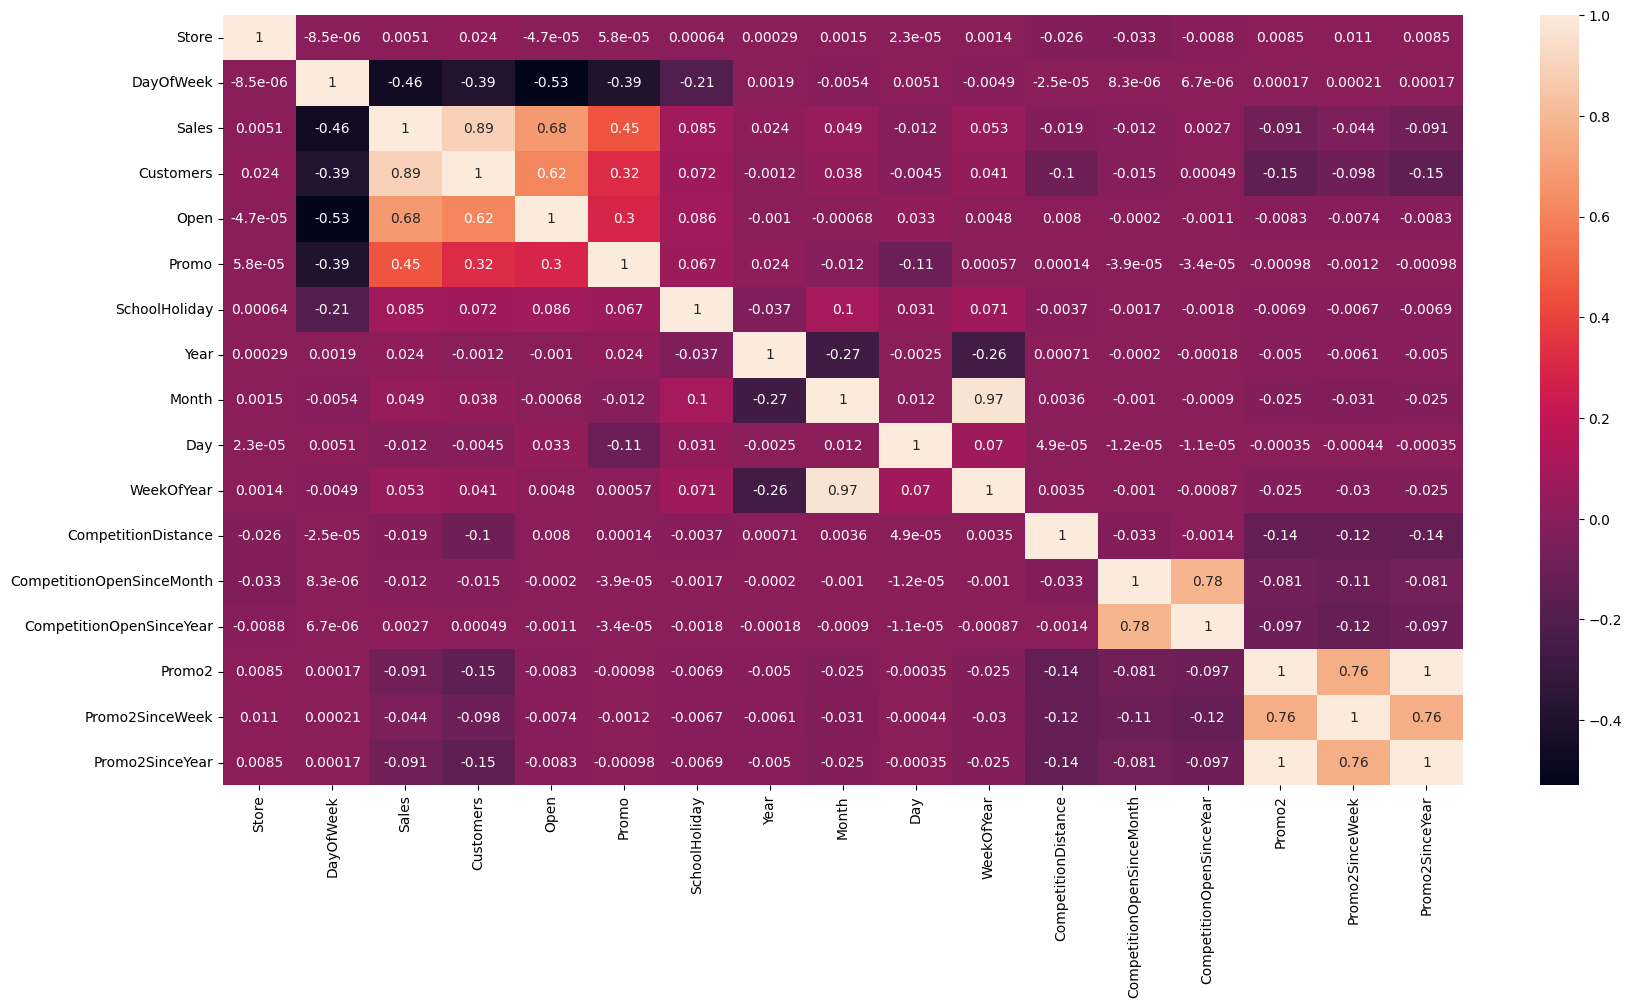

In [21]:
plt.figure(figsize = (20,10))

sns.heatmap(train_store_joined.corr(),annot=True)

# strong positive correlation between the amount of Sales and Customers visiting the store. positive correlation between a running promotion (Promo = 1) and number of customers.

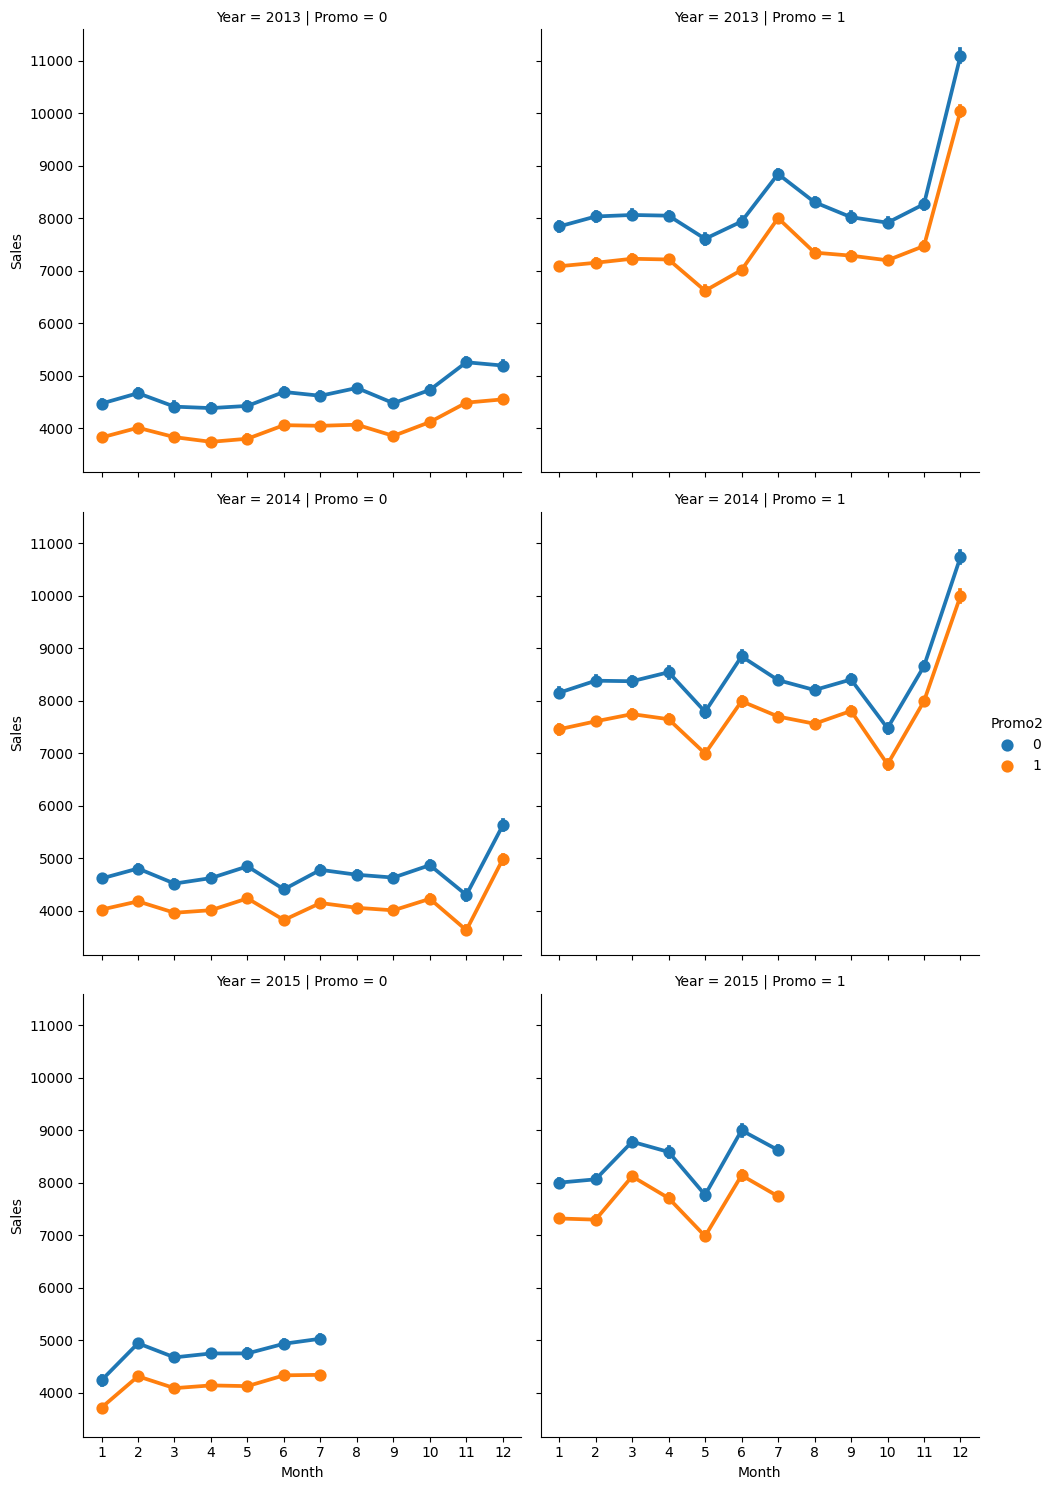

In [22]:
# i want to know what's the sales trend over the months

sns.catplot(data = train_store_joined, x ="Month", y = "Sales",
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year",
               kind = 'point'
             );

#Sales usually peak during november and december

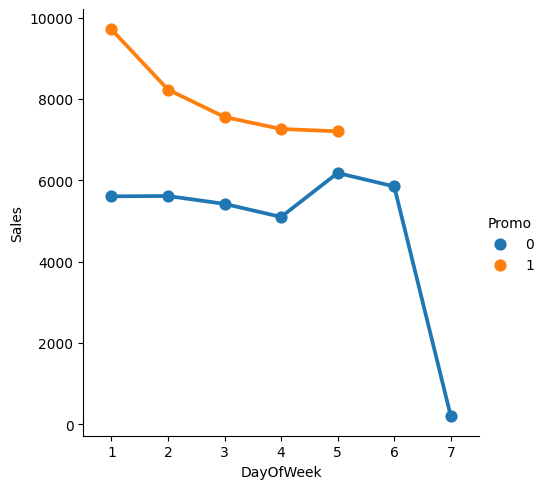

In [23]:
sns.catplot(data = train_store_joined, x = "DayOfWeek", y = "Sales", hue = "Promo", kind = 'point');


EDA summary
a) StoreType is A sell the most.

b) StoreType B has the highest Sale per Customer.

c) Customers tends to buy more on Mondays when there are ongoing promotional offers and on weekend when there is no promotion at all.



In [24]:
test = pd.read_csv('test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [25]:
test.isnull().sum()


Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [26]:
test.fillna(0,inplace = True)

In [27]:
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


# part two

Time Series Analysis & Predictive Modelling

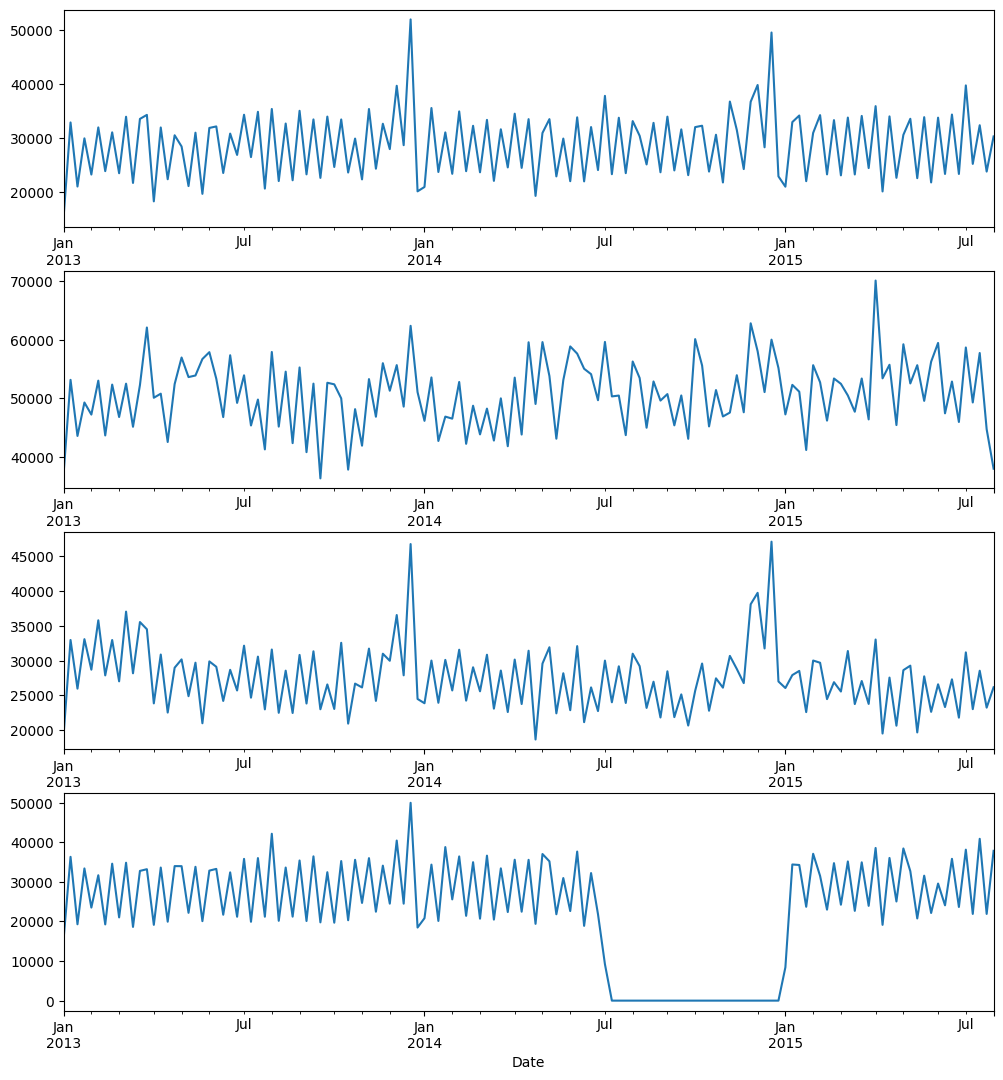

In [28]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

#Stationarity of Time Series

in order to be called stationary, the dataset need to have constant mean, costant varianc , constance covariance.

1. rolling mean
2. dicky- fuller test

In [29]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

In [30]:
test_stationarity(sales_a)


Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [31]:
test_stationarity(sales_b)


Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [32]:
test_stationarity(sales_c)


Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [33]:
test_stationarity(sales_d)


Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


# Checking trend and seasonality in our data.

In [34]:
def plot_timeseries(sales, Storetype):
  fig,axes = plt.subplots(2,1,sharex = True, sharey = False)
  fig.set_figheight(10)
  fig.set_figwidth(15)

  decomposition = seasonal_decompose(sales, model ='additive',period= 365)

  estimated_trend = decomposition.trend
  estimated_seasonal = decomposition.seasonal
  estimated_residual = decomposition.resid

  axes[1].plot(estimated_seasonal,'g',label = 'Seasonality')
  axes[1].legend(loc ='upper left');

  axes[0].plot(estimated_trend,label = 'Trend')
  axes[0].legend(loc = 'upper left');

  plt.title('xx')

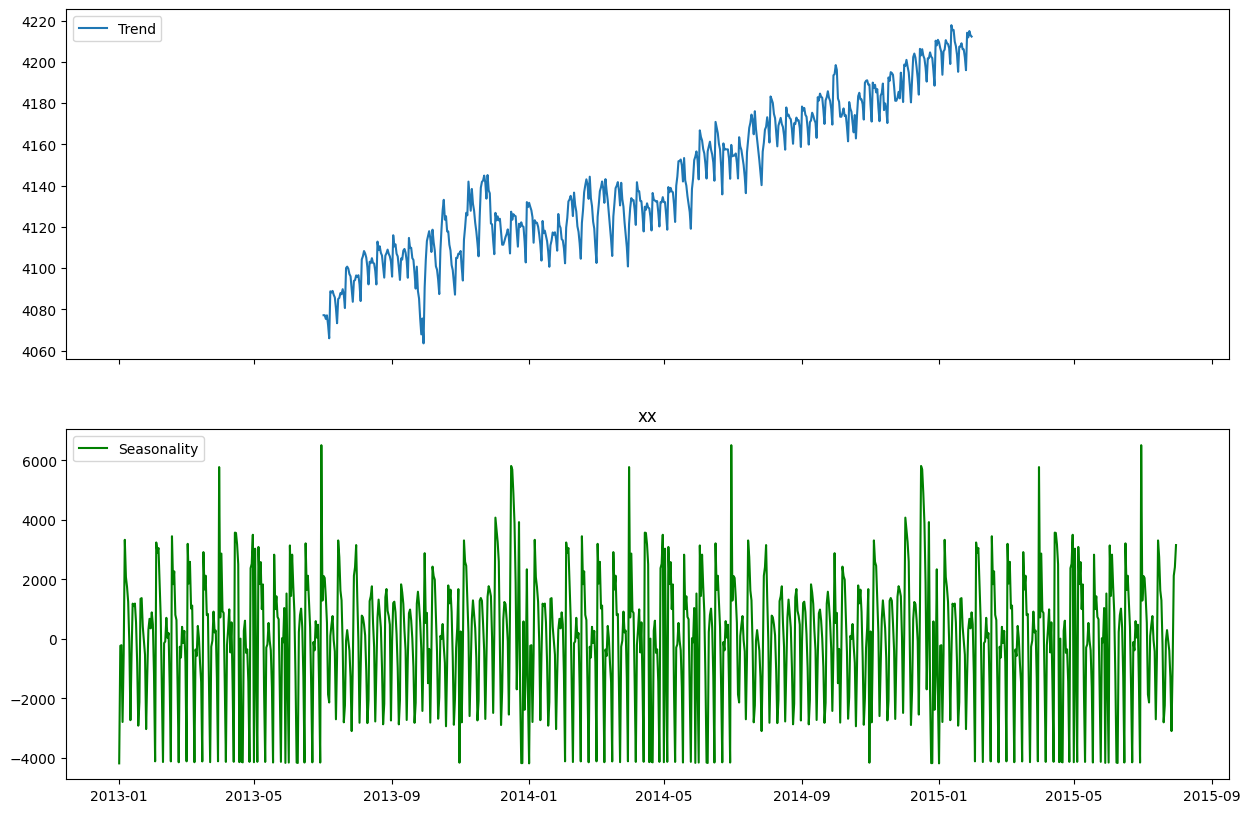

In [35]:
plot_timeseries(sales_a,'a')

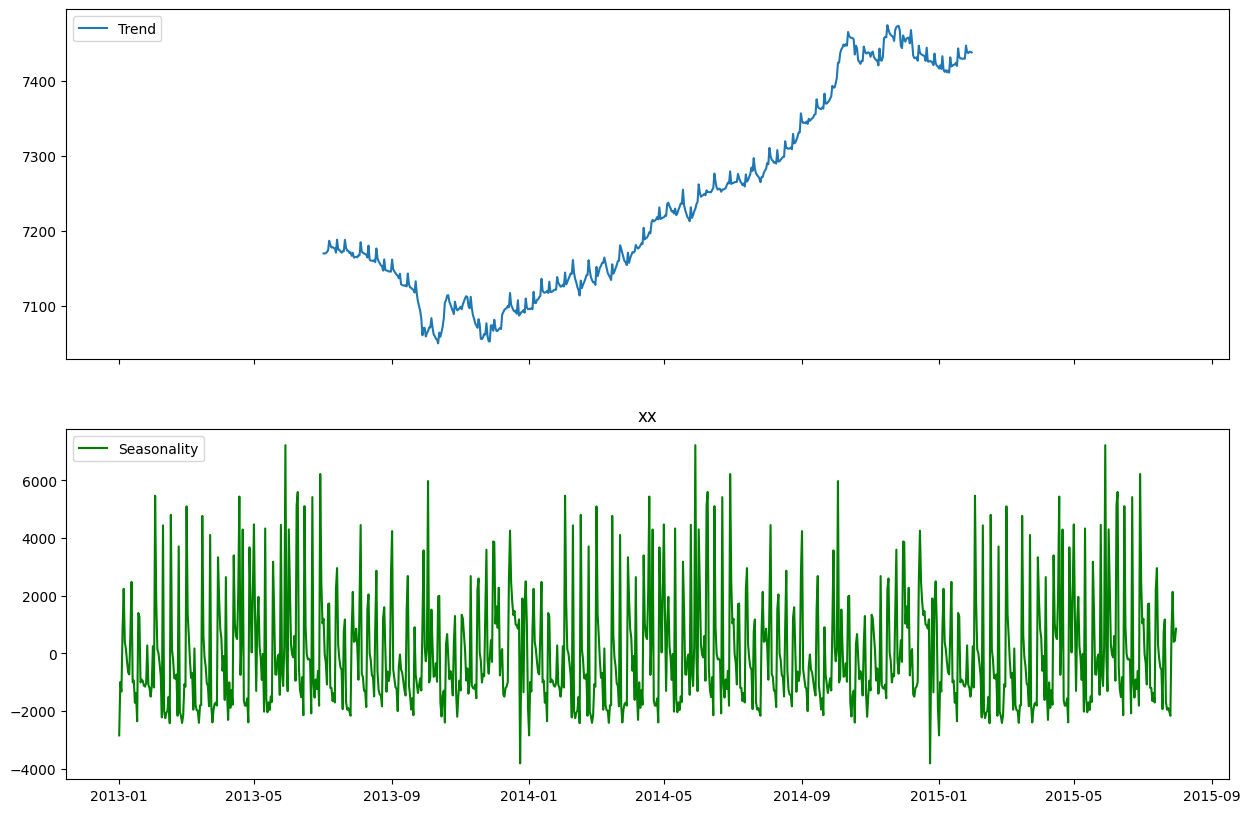

In [36]:
plot_timeseries(sales_b,'b')

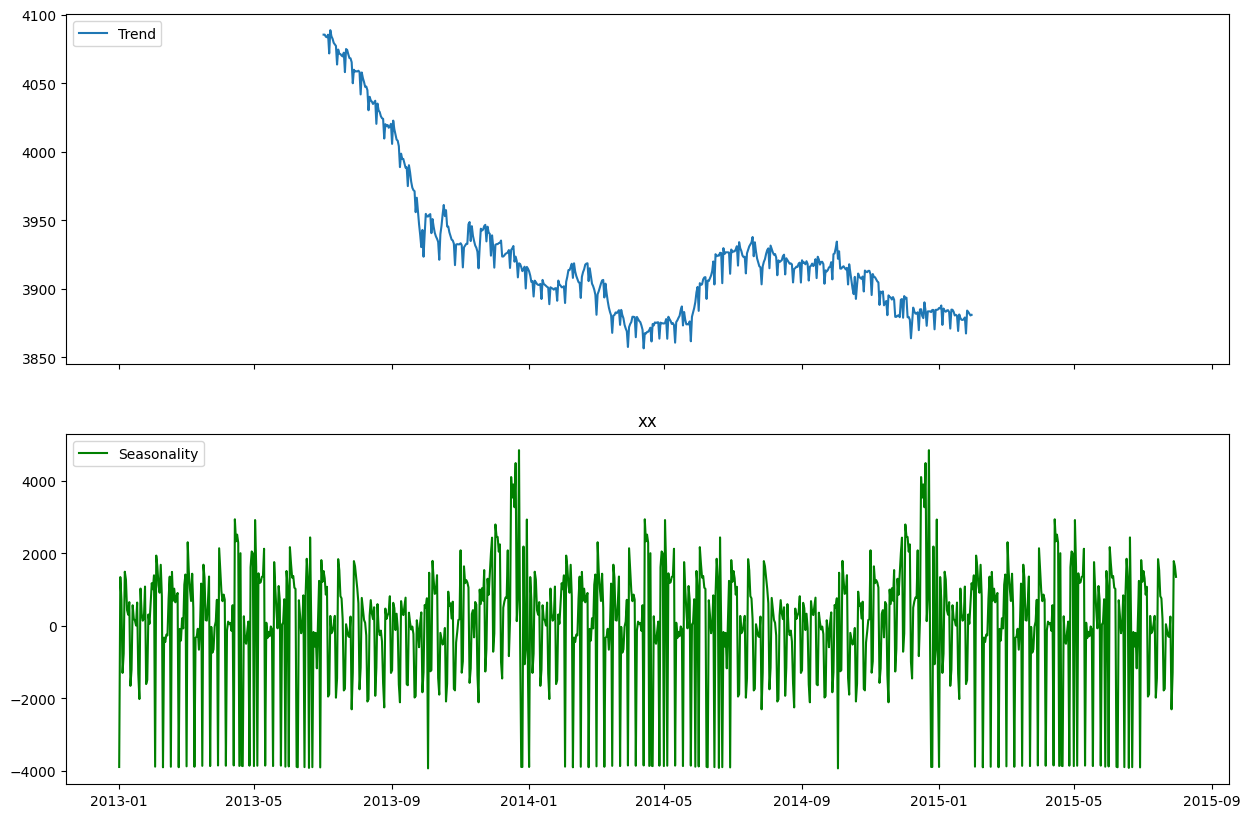

In [37]:
plot_timeseries(sales_c,'c')


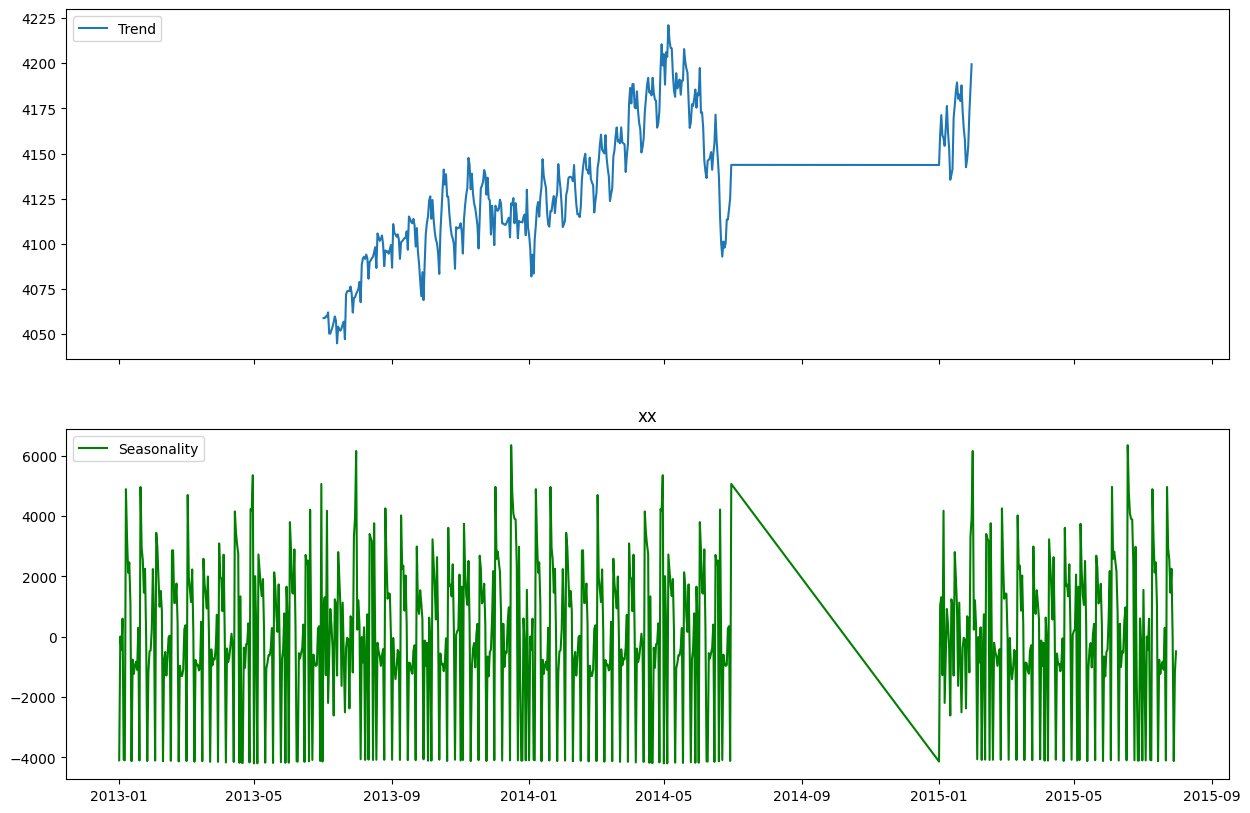

In [38]:
plot_timeseries(sales_d,'d')


In [39]:
# I need to make ACF and pacf graph to determine the term I need to use in my MA model and AR model

def auto_corr(sales):
  lag_acf = acf(sales ,nlags=30)
  lag_pacf = pacf(sales, nlags = 30)

  plt.subplot(121)
  plt.plot(lag_acf)
  plt.axhline(y =0,linestyle = '--')
  plt.title("acf")

  plt.subplot(122)
  plt.plot(lag_pacf)
  plt.axhline(y =0,linestyle = '--')
  plt.title("pacf")


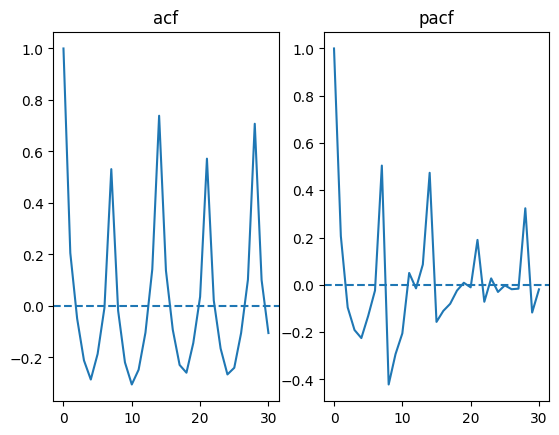

In [40]:
# ACF and PACF for store type a

auto_corr(sales_a)

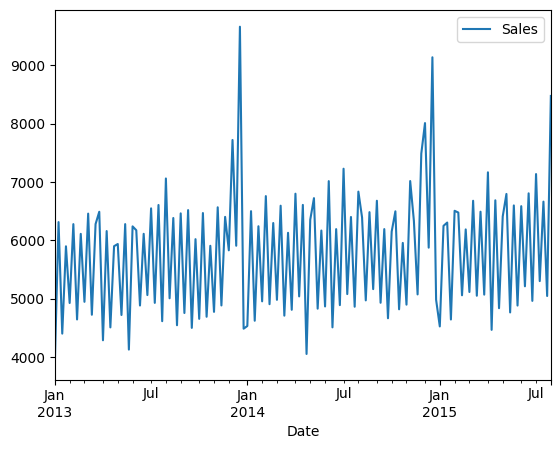

In [41]:
train_arima = train.resample("W").mean()
train_arima = train_arima[["Sales"]]
train_arima.plot();

In [42]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq =[(x[0],x[1],x[2],12)for x in list(itertools.product(p, d, q))]



In [43]:
# Determing p,d,q combinations with AIC scores.
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807689907
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207667
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.82205227971
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791267344
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107309442
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943408078
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305003425
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.017189113569
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.635325966139
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.0426171357803
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908605936769
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089752
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842547886
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.580453193136
ARIM

We can see from the above grid search  ARIMA(1, 1, 1)x(0, 1, 1, 12)12 has the best performance in terms of AIC socre ,
- AIC:1806.2981906705384.




model fitting using hyperparamters tuned above



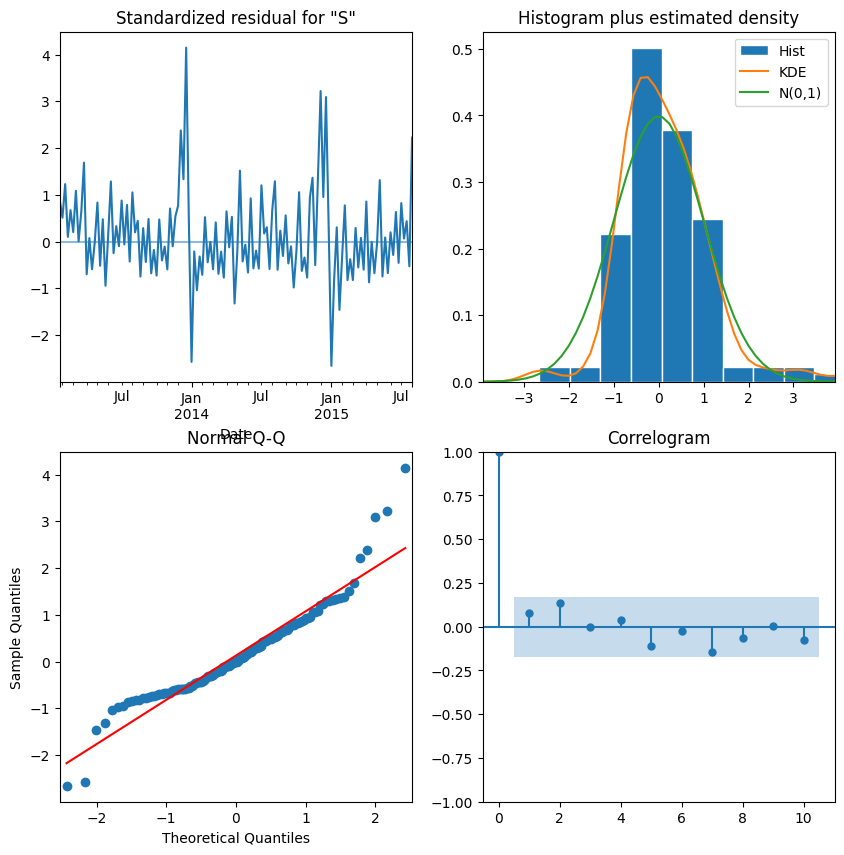

In [44]:
model_sarima = sm.tsa.SARIMAX(train_arima,
                      order = (1,1,1),
                      seasonal_oredr = (0,1,1,12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_sarima = model_sarima.fit()

results_sarima.plot_diagnostics(figsize =(10,10))
plt.show()

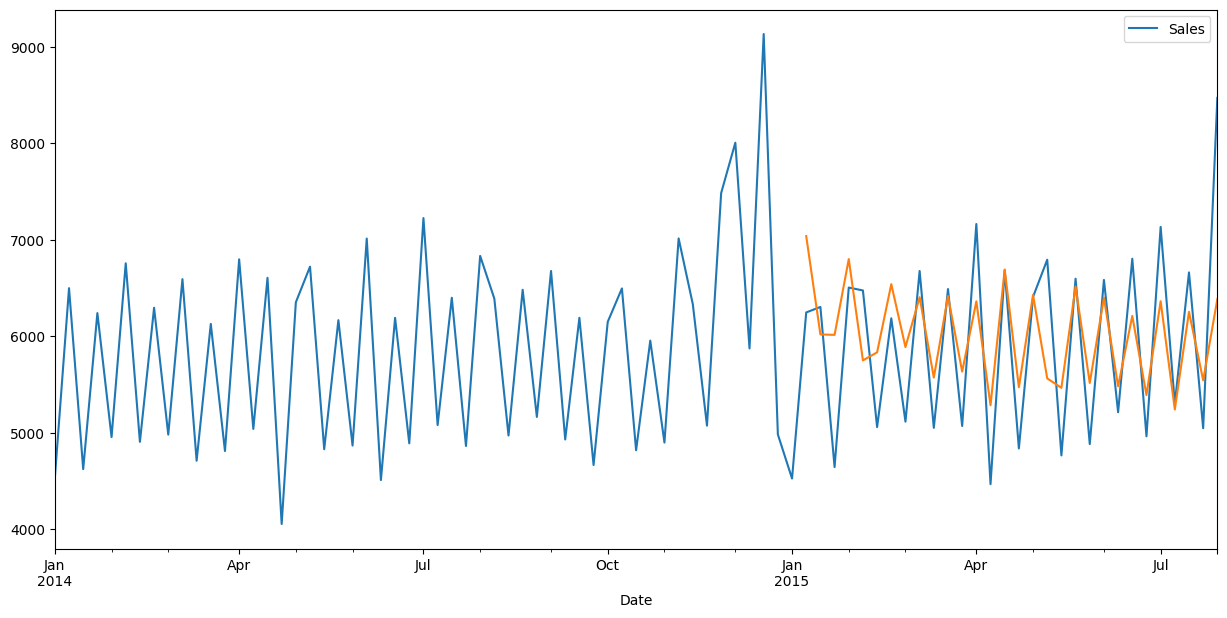

the Root Mean Squared Error for this model is:  714.3811502397477


In [53]:
# Model Prediction and validation
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False)

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)


plt.show()


# i want to know how well the model is doing using RMSE
arima_forecast = pred.predicted_mean
arima_real = train_arima['2015-01-11':]
rmse_arima = sqrt(mean_squared_error(arima_real,arima_forecast))
print("the Root Mean Squared Error for this model is: ",rmse_arima)

